In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import pandas as pd

In [29]:
username = "reddy.bathula"
def watermark(ax, text=username):
    """Adds a watermark to the plot axis."""
    ax.text(0.98, 0.98, text, ha='right', va='top', 
    transform=ax.transAxes, fontsize=10, color='black', alpha=0.6)

In [16]:
class CustomPCA:
    """
    Custom PCA implementation for dimensionality reduction.
    """
    def __init__(self, n_components):
        self.n_components = n_components
        self.components = None
        self.mean = None
        self.explained_variance_ratio_ = None

    def fit(self, X):
        """Fit PCA on the input data."""
        self.mean = np.mean(X, axis=0)
        X_centered = X - self.mean
        cov_matrix = np.cov(X_centered, rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)
        
        sorted_indices = np.argsort(eigenvalues)[::-1]
        sorted_eigenvalues = eigenvalues[sorted_indices]
        sorted_eigenvectors = eigenvectors[:, sorted_indices]
        
        self.components = sorted_eigenvectors[:, :self.n_components]
        
        total_variance = np.sum(sorted_eigenvalues)
        self.explained_variance_ratio_ = sorted_eigenvalues / total_variance

    def transform(self, X):
        """Transform data to lower dimensional space."""
        if self.components is None:
            raise RuntimeError("PCA has not been fitted yet. Call fit() first.")
        X_centered = X - self.mean
        return X_centered @ self.components

In [32]:
class PCAKNNAnalyzer:
    """
    A comprehensive class for PCA and KNN analysis on MNIST digits dataset.
    Handles data loading, PCA transformation, KNN classification, and visualization.
    """
    
    def __init__(self, test_size=0.2, random_state=42):
        self.test_size = test_size
        self.random_state = random_state
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.scaler = None
        self.pca_models = {}
        self.transformed_data = {}
        self.results = {}
        self.detailed_results = []
        
    def load_mnist(self):
        """Load the digits dataset from sklearn."""
        digits = load_digits()
        X, y = digits.data, digits.target
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state, stratify=y
        )
        self.scaler = StandardScaler()
        self.X_train = self.scaler.fit_transform(X_train)
        self.X_test = self.scaler.transform(X_test)
        self.y_train = y_train
        self.y_test = y_test
        return self.X_train, self.X_test, self.y_train, self.y_test

    def train_pca_models(self, n_components_list):
        """Train PCA models for different numbers of components and transform the data."""
        if self.X_train is None:
            raise RuntimeError("Data not loaded. Call load_mnist() first.")
            
        self.pca_models = {}
        self.transformed_data = {}

        for n_components in n_components_list:    
            pca = CustomPCA(n_components=n_components)
            pca.fit(self.X_train)
            
            X_train_pca = pca.transform(self.X_train)
            X_test_pca = pca.transform(self.X_test)
            self.pca_models[n_components] = pca
            self.transformed_data[n_components] = {
                'X_train': X_train_pca,
                'X_test': X_test_pca
            }
        return self.pca_models, self.transformed_data

    def knn_on_pca(self, n_components_list, k_values):
        """Train and evaluate KNN classifiers on PCA-transformed data."""
        if not self.transformed_data:
            raise RuntimeError("PCA models not trained. Call train_pca_models() first.")
            
        self.results = {k: [] for k in k_values}
        self.detailed_results = []
        
        for n_components in n_components_list:
            X_train_pca = self.transformed_data[n_components]['X_train']
            X_test_pca = self.transformed_data[n_components]['X_test']

            for k in k_values:
                knn = KNeighborsClassifier(n_neighbors=k)
                knn.fit(X_train_pca, self.y_train)
                y_pred = knn.predict(X_test_pca)
                accuracy = accuracy_score(self.y_test, y_pred)
                self.results[k].append(accuracy)
                self.detailed_results.append({
                    'n_components': n_components,
                    'k': k,
                    'accuracy': accuracy,
                    'compression_ratio': 64/n_components
                })        

        results_summary_df = pd.DataFrame(self.results, index=n_components_list)
        results_summary_df.index.name = 'Components'
        results_summary_df.columns = [f'k={k}' for k in k_values]

        best_overall = max(self.detailed_results, key=lambda x: x['accuracy'])
        print(f"BEST PERFORMANCE:")
        print(f"Components: {best_overall['n_components']}")
        print(f"k value: {best_overall['k']}")
        print(f"Accuracy: {best_overall['accuracy']:.4f}")
        print(f"Compression: {best_overall['compression_ratio']:.1f}x")
        return results_summary_df, self.detailed_results

    def plot_results(self, n_components_list):
        """Plot KNN classification accuracy vs number of principal components."""
        if not self.results:
            raise RuntimeError("No results to plot. Run knn_on_pca() first.")
            
        plt.figure(figsize=(14, 8))
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Different colors for each k
        markers = ['o', 's', '^', 'D']  # Different markers for each k

        for i, (k, accuracies) in enumerate(self.results.items()):
            plt.plot(n_components_list, accuracies, 
                    marker=markers[i], linestyle='-', linewidth=2, markersize=8,
                    color=colors[i], label=f'k = {k}')

        plt.title('KNN Classification Accuracy vs Number of Principal Components', fontsize=16)
        plt.xlabel('Number of Principal Components', fontsize=12)
        plt.ylabel('Classification Accuracy', fontsize=12)
        plt.xticks(n_components_list)
        plt.legend(title='Number of Neighbors (k)', fontsize=11, title_fontsize=12)
        plt.grid(True, alpha=0.3)


        for i, (k, accuracies) in enumerate(self.results.items()):
            max_acc_idx = np.argmax(accuracies)
            max_acc = accuracies[max_acc_idx]
            max_comp = n_components_list[max_acc_idx]
            
            plt.annotate(f'{max_acc:.3f}', 
                        xy=(max_comp, max_acc), 
                        xytext=(5, 5), textcoords='offset points',
                        fontsize=9, color=colors[i], weight='bold')
        
        watermark(plt.gca())
        plt.tight_layout()
        plt.show()

    def run_pipeline(self, n_components_list, k_values):
        """Execute the complete PCA-KNN analysis pipeline."""
        self.load_mnist()
        self.train_pca_models(n_components_list)
        results_summary_df, detailed_results = self.knn_on_pca(n_components_list, k_values)
        print("\nSummary of Results:")
        print(results_summary_df)
        self.plot_results(n_components_list)
        return results_summary_df, detailed_results

BEST PERFORMANCE:
Components: 40
k value: 5
Accuracy: 0.9722
Compression: 1.6x

Summary of Results:
                 k=5      k=25      k=50     k=100
Components                                        
2           0.522222  0.536111  0.519444  0.525000
5           0.830556  0.813889  0.788889  0.761111
10          0.944444  0.908333  0.861111  0.847222
20          0.952778  0.933333  0.897222  0.883333
30          0.969444  0.922222  0.900000  0.883333
40          0.972222  0.933333  0.905556  0.886111
50          0.969444  0.938889  0.908333  0.888889
64          0.963889  0.941667  0.905556  0.886111


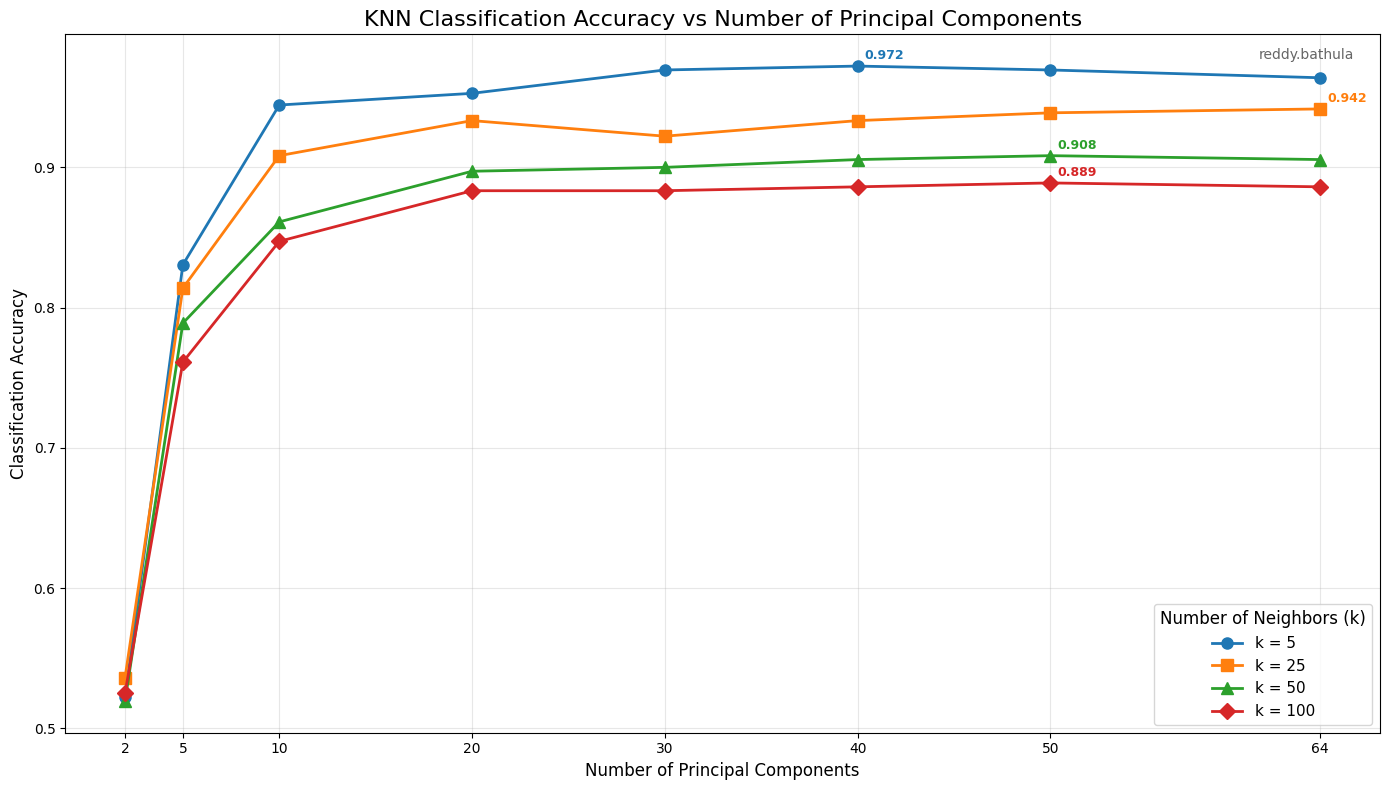

In [33]:
analyzer = PCAKNNAnalyzer(random_state=42)
results_df, detailed_results = analyzer.run_pipeline(
    n_components_list=[2, 5, 10, 20, 30, 40, 50, 64], 
    k_values=[5, 25, 50, 100]
)

## Observations

- Principal Components on Accuracy of KNN
    - With very few components (2–5), the accuracy is low (~0.5–0.8) because not enough variance is captured.

    - Accuracy increases sharply as the number of components increases up to around 10–20 components.

    - Beyond ~30 components, the improvement flattens out, indicating that most of the useful variance is already captured by the first 20–30 components.

- Influence of K

    - Lower k (k=5) achieves the highest accuracy (~0.97). This suggests KNN benefits from more localized decision boundaries when the data is well-represented.

    - Value of K and the accuracy behave inversely to each other. As K increases, accuracy decreases.

- Diminishing Returns

    - Accuracy gains are substantial up to ~20–30 components. Beyond this, additional components do not significantly improve accuracy, regardless of k.


PCA effectively reduces dimensionality while retaining discriminative power.

Using ~30 principal components balances performance and efficiency.

Smaller k values in KNN yield better classification on PCA-reduced MNIST, while larger k trades accuracy for smoother generalization.